In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pyBigWig
import pysam
from tqdm import tqdm
from scipy import stats

In [2]:
pal = {
    'PTA': '#FF1B5E',
    'MDA': '#FFDB57',
    'LIANTI': '#438CFD',
    'MALBAC': '#FF8C00',
    'Bulk': '#80F15E',
    'Capsule Cell Growth': '#03FFFF',
    'Capsule PTA': '#5941A9',
    'Capsule mMDA': '#E980FC',
    
}

### Load Public Data

In [3]:
PTA_meta = pd.read_csv('../bin/coverage_benchmarking/PTA_meta.tsv', sep='\t', index_col='SRA_Run')
PTA_meta=PTA_meta[PTA_meta['amplification_method'].isin(['PTA','SCMDA'])]
def rename(row):
    if row.amplification_method=='SCMDA':
        return 'MDA' 
    else:
        return row.amplification_method
PTA_meta['amplification_method'] = PTA_meta.apply(rename, axis=1)
PTA_meta['study']='Gonzalez-Pena'
PTA_meta=PTA_meta[['study','amplification_method']]
# PTA_meta

In [4]:
PTA_qc = pd.read_csv('../results/coverage_benchmarking/PTA_qc_summary.csv', index_col='sample')
PTA_qc = PTA_qc.loc[PTA_meta.index]
PTA_data = pd.concat([PTA_meta, PTA_qc], axis=1)
PTA_data.rename_axis(index="sample", inplace=True)

In [5]:
ginis = []
for name in PTA_data.index:
    with open(f'../data/coverage_benchmarking/{name}_gini.txt', 'r') as fin:
        ginis.append(float(fin.readline().strip()))
PTA_data['gini'] = ginis

In [6]:
LIANTI_meta = pd.read_csv('../bin/coverage_benchmarking/LIANTI_meta.tsv', sep='\t', index_col='SRA_Run')
LIANTI_meta['study'] = 'Chen'

def amp(row):
    if 'LIANTI' in row.replicate:
        return 'LIANTI' 
    elif 'MDA' in row.replicate:
        return 'MDA' 
    elif 'MALBAC' in row.replicate:
        return 'MALBAC'
    elif 'Bulk' in row.replicate:
        return 'Bulk'
    
LIANTI_meta['amplification_method'] = LIANTI_meta.apply(amp, axis=1)
LIANTI_meta = LIANTI_meta[LIANTI_meta['amplification_method'].isin(['LIANTI','MDA','MALBAC','Bulk'])]
LIANTI_meta = LIANTI_meta[['study','amplification_method']]
# LIANTI_meta

In [7]:
LIANTI_qc = pd.read_csv('../results/coverage_benchmarking/LIANTI_qc_summary.csv', index_col='sample')
LIANTI_qc = LIANTI_qc.loc[LIANTI_meta.index]
LIANTI_data = pd.concat([LIANTI_meta, LIANTI_qc], axis=1)
LIANTI_data.rename_axis(index="sample", inplace=True)

In [8]:
ginis = []
for name in LIANTI_data.index:
    with open(f'../data/coverage_benchmarking/{name}_gini.txt', 'r') as fin:
        ginis.append(float(fin.readline().strip()))
LIANTI_data['gini'] = ginis

### Load CapWGS Data

In [9]:
with open('../bin/HSC_CellGrowth_coverage/real_cells.txt', 'r') as fin:
    Cell_Div_names = [line.strip() for line in fin]
with open('../bin/HSC_enzyme_coverage/real_cells.txt', 'r') as fin:
    Enzyme_amp_names = [line.strip() for line in fin]

In [10]:
Enzyme_amp_dict = {}
for cell in Enzyme_amp_names:
    if 'CTGTGAAC' in cell or 'ACATCGTC' in cell or 'TTGGATGC' in cell or 'GTTACGGT' in cell:
        Enzyme_amp_dict[cell]="Capsule PTA"
    elif 'TGGTCTCA' in cell or 'TCCAGGAT' in cell or 'CATACCGT' in cell or 'TTCCACTC' in cell:
        Enzyme_amp_dict[cell]="Capsule mMDA"
    elif 'GTGACTCT' in cell or 'GGCATCAA' in cell or 'AGATACCG' in cell or 'TTGATGGC' in cell:
        Enzyme_amp_dict[cell]="Capsule PTA"
    elif 'CGACCTAT' in cell or 'TCCTCAAC' in cell or 'TTGACCAC' in cell or 'GATGGTCT' in cell:
        Enzyme_amp_dict[cell]="Capsule mMDA"
    elif 'CGGTAAGT' in cell or 'TGACAGTG' in cell or 'CACTGACA' in cell or 'GTCGGTAA' in cell:
        Enzyme_amp_dict[cell]="Capsule PTA"
    elif 'GTAACCGA' in cell or 'GTCCGATT' in cell or 'GACAGCAT' in cell or 'CGGTTGAT' in cell:
        Enzyme_amp_dict[cell]="Capsule mMDA"
Enzyme_amp_meta = pd.DataFrame.from_dict(Enzyme_amp_dict, orient='index', columns=['amplification_method'])
Enzyme_amp_meta['Fragmentation Time'] = None
Enzyme_amp_meta['study'] = 'CapWGS'

In [11]:
Enzyme_amp_qc = pd.read_csv('../results/coverage_benchmarking/HSC_enzyme_coverage_qc_summary.csv', index_col='sample')
Enzyme_amp_qc = Enzyme_amp_qc.loc[Enzyme_amp_meta.index]
Enzyme_amp_qc.rename_axis(index="sample", inplace=True)
Enzyme_amp_data = pd.concat([Enzyme_amp_meta, Enzyme_amp_qc], axis=1)


In [12]:
ginis = []
for name in Enzyme_amp_data.index:
    with open(f'../data/HSC_enzyme_coverage/sc_outputs/{name}_gini.txt', 'r') as fin:
        ginis.append(float(fin.readline().strip()))
Enzyme_amp_data['gini'] = ginis

In [13]:
Enzyme_amp_data.index = Enzyme_amp_data.index.astype(str) + '_enz'

In [14]:
Cell_Div_dict = {}
for cell in Cell_Div_names:
    if 'CTGTGAAC' in cell or 'ACATCGTC' in cell or 'TTGGATGC' in cell or 'GTTACGGT' in cell:
        Cell_Div_dict[cell]="45min"
    elif 'TGGTCTCA' in cell or 'TCCAGGAT' in cell or 'CATACCGT' in cell or 'TTCCACTC' in cell:
        Cell_Div_dict[cell]="30min"
    elif 'GTGACTCT' in cell or 'GGCATCAA' in cell or 'AGATACCG' in cell or 'TTGATGGC' in cell:
        Cell_Div_dict[cell]="45min"
    elif 'CGACCTAT' in cell or 'TCCTCAAC' in cell or 'TTGACCAC' in cell or 'GATGGTCT' in cell:
        Cell_Div_dict[cell]="30min"
    elif 'CGGTAAGT' in cell or 'TGACAGTG' in cell or 'CACTGACA' in cell or 'GTCGGTAA' in cell:
        Cell_Div_dict[cell]="45min"
    elif 'GTAACCGA' in cell or 'GTCCGATT' in cell or 'GACAGCAT' in cell or 'CGGTTGAT' in cell:
        Cell_Div_dict[cell]="30min"
Cell_Div_meta = pd.DataFrame.from_dict(Cell_Div_dict, orient='index', columns=['Fragmentation Time'])
Cell_Div_meta['amplification_method'] = 'Capsule Cell Growth'
Cell_Div_meta['study'] = 'CapWGS'

In [15]:
Cell_Div_qc = pd.read_csv('../results/coverage_benchmarking/HSC_CellGrowth_coverage_qc_summary.csv', index_col='sample')
Cell_Div_qc = Cell_Div_qc.loc[Cell_Div_meta.index]
Cell_Div_qc.rename_axis(index="sample", inplace=True)
Cell_Div_data = pd.concat([Cell_Div_meta, Cell_Div_qc], axis=1)


In [16]:
ginis = []
for name in Cell_Div_data.index:
    with open(f'../data/HSC_CellGrowth_coverage/sc_outputs/{name}_gini.txt', 'r') as fin:
        ginis.append(float(fin.readline().strip()))
Cell_Div_data['gini'] = ginis

In [17]:
Cell_Div_data.index = Cell_Div_data.index.astype(str) + '_CG'

In [18]:
CapWGS_data = pd.concat([Enzyme_amp_data, Cell_Div_data])
# CapWGS_data

### Compile

In [19]:
data = pd.concat([PTA_data, LIANTI_data, CapWGS_data])
data

,study,amplification_method,pct_reads_aligned,mean_read_length,reads_aligned,total_reads,at_dropout,gc_dropout,pct_duplicates,read_pairs_examined,read_pair_duplicates,mean_coverage,median_coverage,pct_1x,pct_10x,gini,Fragmentation Time
SRR8438254,Gonzalez-Pena,PTA,0.998890,142.328266,393373122,393810332,2.463873,3.953465,0.264538,393058249.0,103906582.0,29.582088,24.0,0.944510,0.777034,0.346149,NaN
SRR8438256,Gonzalez-Pena,PTA,0.998999,142.087322,376201472,376578419,3.084621,2.600622,0.172425,375853409.0,64717620.0,28.365647,22.0,0.946975,0.772341,0.353197,NaN
SRR8438258,Gonzalez-Pena,PTA,0.998965,142.257909,397358060,397769597,2.353022,4.301985,0.211232,396960198.0,83758787.0,30.239498,25.0,0.947363,0.788415,0.337549,NaN
SRR8438259,Gonzalez-Pena,PTA,0.998896,141.950284,403413288,403859008,2.474044,4.007757,0.222852,403083571.0,89745871.0,30.415738,25.0,0.945227,0.783495,0.344968,NaN
SRR8438298,Gonzalez-Pena,PTA,0.998929,142.211162,390038638,390456866,2.505916,4.156542,0.194874,389678898.0,75850471.0,29.205149,24.0,0.947178,0.785615,0.333530,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CGCTAGTTAGGAGGAACCAAACTCTGTTGGACAAGGTGGTCTCAA_CG,CapWGS,Capsule Cell Growth,0.998702,153.297987,60648491,60727303,0.924962,1.215217,0.957355,60607400.0,58023829.0,3.809644,0.0,0.123187,0.093561,0.485127,30min
CGGTAGAAAGGAAGATGGTCACTCAGGTCGTAAAGGCACTGACAA_CG,CapWGS,Capsule Cell Growth,0.999298,153.393974,59008521,59049954,0.510553,0.717477,0.958925,58983044.0,56561389.0,3.754804,0.0,0.119449,0.093196,0.474071,45min
ACTAACCGAGGAGTCTGCTAACTCACAGTAGCAAGGTCCTCAACA_CG,CapWGS,Capsule Cell Growth,0.998782,153.358804,58499252,58570589,0.524519,1.295298,0.959377,58456154.0,56082571.0,3.683172,0.0,0.114657,0.089325,0.476930,30min
ATCGACAGAGGACTGCTCAAACTCTGTTGGACAAGGGTAACCGAA_CG,CapWGS,Capsule Cell Growth,0.997899,153.270479,51935987,52045310,1.156218,1.831591,0.956818,51897766.0,49658480.0,3.258441,0.0,0.109123,0.080600,0.495667,30min


In [20]:
print(f"Gonzalez-Pena reads per cell: {data[data['study']=='Gonzalez-Pena']['read_pairs_examined'].mean():.0f}")
print(f"Gonzalez-Pena coverage per cell: {data[data['study']=='Gonzalez-Pena']['mean_coverage'].mean():.0f}")
print('\n')
print(f"Chen reads per cell: {data[data['study']=='Chen']['read_pairs_examined'].mean():.0f}")
print(f"Chen coverage per cell: {data[data['study']=='Chen']['mean_coverage'].mean():.0f}")
print('\n')
print(f"CapWGS reads per cell: {data[data['study']=='CapWGS']['read_pairs_examined'].mean():.0f}")
print(f"CapWGS coverage per cell: {data[data['study']=='CapWGS']['mean_coverage'].mean():.3f}")

Gonzalez-Pena reads per cell: 473045355
Gonzalez-Pena coverage per cell: 25


Chen reads per cell: 305379847
Chen coverage per cell: 13


CapWGS reads per cell: 149971008
CapWGS coverage per cell: 9.265


# Plot QC Metrics

In [21]:
data

,study,amplification_method,pct_reads_aligned,mean_read_length,reads_aligned,total_reads,at_dropout,gc_dropout,pct_duplicates,read_pairs_examined,read_pair_duplicates,mean_coverage,median_coverage,pct_1x,pct_10x,gini,Fragmentation Time
SRR8438254,Gonzalez-Pena,PTA,0.998890,142.328266,393373122,393810332,2.463873,3.953465,0.264538,393058249.0,103906582.0,29.582088,24.0,0.944510,0.777034,0.346149,NaN
SRR8438256,Gonzalez-Pena,PTA,0.998999,142.087322,376201472,376578419,3.084621,2.600622,0.172425,375853409.0,64717620.0,28.365647,22.0,0.946975,0.772341,0.353197,NaN
SRR8438258,Gonzalez-Pena,PTA,0.998965,142.257909,397358060,397769597,2.353022,4.301985,0.211232,396960198.0,83758787.0,30.239498,25.0,0.947363,0.788415,0.337549,NaN
SRR8438259,Gonzalez-Pena,PTA,0.998896,141.950284,403413288,403859008,2.474044,4.007757,0.222852,403083571.0,89745871.0,30.415738,25.0,0.945227,0.783495,0.344968,NaN
SRR8438298,Gonzalez-Pena,PTA,0.998929,142.211162,390038638,390456866,2.505916,4.156542,0.194874,389678898.0,75850471.0,29.205149,24.0,0.947178,0.785615,0.333530,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CGCTAGTTAGGAGGAACCAAACTCTGTTGGACAAGGTGGTCTCAA_CG,CapWGS,Capsule Cell Growth,0.998702,153.297987,60648491,60727303,0.924962,1.215217,0.957355,60607400.0,58023829.0,3.809644,0.0,0.123187,0.093561,0.485127,30min
CGGTAGAAAGGAAGATGGTCACTCAGGTCGTAAAGGCACTGACAA_CG,CapWGS,Capsule Cell Growth,0.999298,153.393974,59008521,59049954,0.510553,0.717477,0.958925,58983044.0,56561389.0,3.754804,0.0,0.119449,0.093196,0.474071,45min
ACTAACCGAGGAGTCTGCTAACTCACAGTAGCAAGGTCCTCAACA_CG,CapWGS,Capsule Cell Growth,0.998782,153.358804,58499252,58570589,0.524519,1.295298,0.959377,58456154.0,56082571.0,3.683172,0.0,0.114657,0.089325,0.476930,30min
ATCGACAGAGGACTGCTCAAACTCTGTTGGACAAGGGTAACCGAA_CG,CapWGS,Capsule Cell Growth,0.997899,153.270479,51935987,52045310,1.156218,1.831591,0.956818,51897766.0,49658480.0,3.258441,0.0,0.109123,0.080600,0.495667,30min


/loc/scratch/43992537/ipykernel_29919/66234033.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x="amplification_method", y="gini", order=['Bulk','MALBAC','MDA','LIANTI','PTA','Capsule mMDA', 'Capsule PTA', 'Capsule Cell Growth'],


Text(0, 0.5, 'Gini Coefficient')

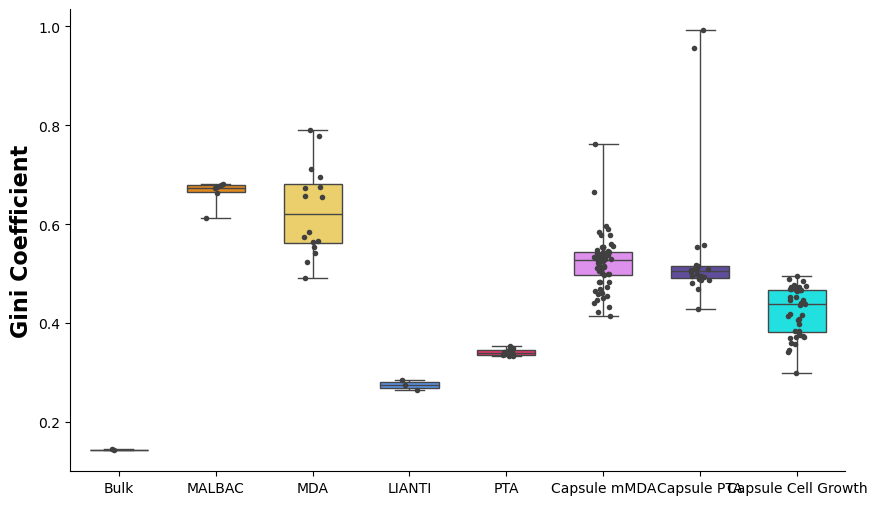

In [22]:
# sns.set_theme(style="ticks", palette="pastel")
fig,ax = plt.subplots(1,1,figsize=(10,6))
sns.boxplot(data=data, x="amplification_method", y="gini", order=['Bulk','MALBAC','MDA','LIANTI','PTA','Capsule mMDA', 'Capsule PTA', 'Capsule Cell Growth'],
            ax=ax,
            palette=pal,
            whis=(0,100),
            width=.6
           )

sns.stripplot(data=data, x="amplification_method", y="gini", order=['Bulk','MALBAC','MDA','LIANTI','PTA','Capsule mMDA', 'Capsule PTA', 'Capsule Cell Growth'],
              ax=ax,
              size=4, 
              color=".25"
             )

sns.despine()
plt.xlabel('')
# plt.ylim(0.175,0.4)
plt.ylabel('Gini Coefficient', fontdict={'weight':'bold','size':16})

# Load and Plot Lorenz Curves

In [23]:
public_data_lorenz = pd.read_csv('../results/coverage_benchmarking/public_data_lorenz_curves.csv', index_col=0)

CellGrowth_lorenz = pd.read_csv('../results/coverage_benchmarking/HSC_CellGrowth_coverage_lorenz_curves.csv', index_col=0)
CellGrowth_lorenz.columns = CellGrowth_lorenz.columns.astype(str) + '_CG'

enzyme_lorenz = pd.read_csv('../results/coverage_benchmarking/HSC_enzyme_coverage_lorenz_curves.csv', index_col=0)
enzyme_lorenz.columns = enzyme_lorenz.columns.astype(str) + '_enz'

lorenz_curves = pd.concat([public_data_lorenz, CellGrowth_lorenz, enzyme_lorenz], axis=1)
# lorenz_curves

Text(0, 0.5, 'Cumulative Fraction of Total Reads')

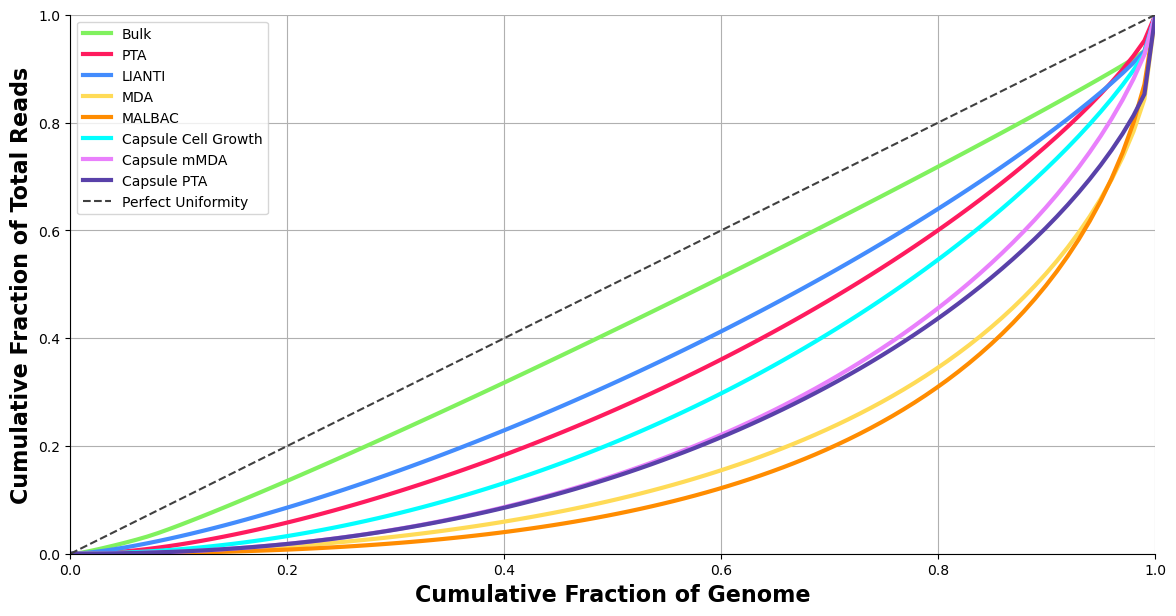

In [24]:
# Calculate mean and standard deviation of Lorenz curves for each group
mean_curves = {}
std_curves = {}
for group in data['amplification_method'].unique():
    subset = lorenz_curves[data[data['amplification_method']==group].index]  # Select Lorenz curves for the group
    mean_curves[group] = subset.mean(axis=1)  # Mean across barcodes
    std_curves[group] = subset.std(axis=1)    # Standard deviation across barcodes

# Convert to DataFrame for plotting
common_x = lorenz_curves.index
mean_df = pd.DataFrame(mean_curves)
std_df = pd.DataFrame(std_curves)

plt.figure(figsize=(14, 7))
plt.plot(common_x, mean_df['Bulk'], label='Bulk', color=pal['Bulk'], linewidth=3)
plt.plot(common_x, mean_df['PTA'], label='PTA', color=pal['PTA'], linewidth=3)
plt.plot(common_x, mean_df['LIANTI'], label='LIANTI', color=pal['LIANTI'], linewidth=3)
plt.plot(common_x, mean_df['MDA'], label='MDA', color=pal['MDA'], linewidth=3)
plt.plot(common_x, mean_df['MALBAC'], label='MALBAC', color=pal['MALBAC'], linewidth=3)
plt.plot(common_x, mean_df['Capsule Cell Growth'], label='Capsule Cell Growth', color=pal['Capsule Cell Growth'], linewidth=3)
plt.plot(common_x, mean_df['Capsule mMDA'], label='Capsule mMDA', color=pal['Capsule mMDA'], linewidth=3)
plt.plot(common_x, mean_df['Capsule PTA'], label='Capsule PTA', color=pal['Capsule PTA'], linewidth=3)
plt.grid(True)
plt.plot([0,1],[0,1], color='.25', linestyle='--', label='Perfect Uniformity')
plt.legend(title='')
sns.despine()
plt.ylim(0,1)
plt.xlim(0,1)
plt.xlabel('Cumulative Fraction of Genome', fontdict={'weight':'bold','size':16})
plt.ylabel('Cumulative Fraction of Total Reads', fontdict={'weight':'bold','size':16})